In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
import glob
import pickle
import nelpy.plotting as npl

from ripple_heterogeneity.replay import replay_fig
from scipy import stats
from ripple_heterogeneity.utils import custom_plots
from ripple_heterogeneity.replay import wmaze_replay
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
# import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
import os
from scipy import stats
from statannot import add_stat_annotation
from scipy.ndimage import gaussian_filter1d
import warnings
functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [9]:
basepath = r"Z:\Data\ORproject\OR22\day1"
max_distance_from_well=20  # in cm, max distance from well to consider a well traversal
min_distance_traveled=50  
speed_thres = 4
ds_50ms=0.05
s_binsize=3
tuning_curve_sigma=3
place_cell_min_rate=1
place_cell_min_spks=100
place_cell_peak_mean_ratio=1.5

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray([np.array([epoch_df.startTime, epoch_df.stopTime]).T])

position_df = loading.load_animal_behavior(basepath)
# remove nan values
bad_idx = np.isnan(position_df.linearized)
position_df = position_df[~bad_idx]

# add position to nelpy array
pos = nel.AnalogSignalArray(
    data=np.array(position_df.linearized),
    timestamps=position_df.time,
    fs=position_df.sr.iloc[0],
)
# restrict to wmaze
pos = pos[beh_epochs[epoch_df.environment == "wmaze"]]


# locate each trajectory start and end
trajectories = wmaze_replay.get_w_maze_trajectories(
    position_df,
    max_distance_from_well=max_distance_from_well,
    min_distance_traveled=min_distance_traveled,
)

st_all, cell_metrics = loading.load_spikes(basepath,brainRegion="CA1",putativeCellType="Pyr")
cell_metrics = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cell_metrics)



In [39]:
tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
    pos, st_all, trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
)

In [45]:
ratemap.append(tc.ratemap)

(48, 71)

In [55]:
np.linspace(0,100,tc.ratemap.shape[1]).shape

(71,)

In [69]:
ratemap = [np.interp(np.linspace(0,100,100),np.linspace(0,100,tc.ratemap.shape[1]),rate) for rate in tc.ratemap]
ratemap = np.array(ratemap)

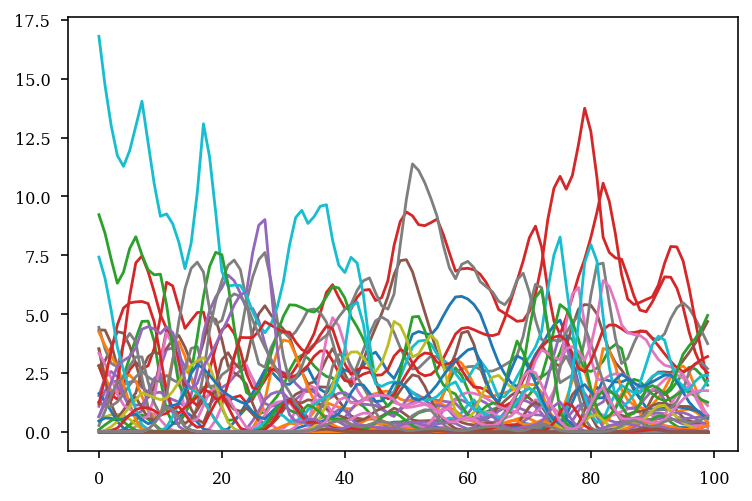

In [70]:
plt.plot(ratemap.T)
plt.show()

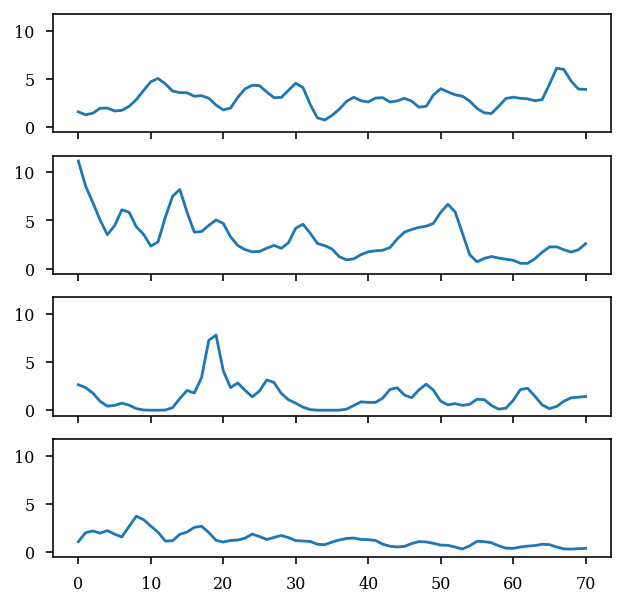

In [38]:
cell = 4
fig,ax = plt.subplots(4,1,figsize=(5,5),sharex=True,sharey=True)
for traj_i,traj in enumerate(trajectories.keys()):

    tc, st_run, bst_run = wmaze_replay.get_tuning_curves(
        pos, st_all.iloc[:,cell], trajectories[traj], speed_thres, ds_50ms, s_binsize, tuning_curve_sigma
    )
    ax[traj_i].plot(tc.ratemap[0])

In [17]:
peak_firing_rates = tc.max(axis=1)
mean_firing_rates = tc.mean(axis=1)
ratio = peak_firing_rates / mean_firing_rates
np.where(
    (cell_metrics.deepSuperficial == "Deep")
    & (tc.ratemap.max(axis=1) > place_cell_min_rate)
    & (st_run.n_events > place_cell_min_spks)
    & (ratio >= place_cell_peak_mean_ratio)
)


(array([ 3,  4, 15, 17, 23, 27, 39, 42, 46], dtype=int64),)